# Pré-Processamento


Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import math
import plotly.express as px

É bem provável que eu importe uma mesma biblioteca mais de uma vez. Faço isso para não ter que voltar e ve se importei

Nessa parte eu chamo o dataFrame pelo meu Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/IEEE/cinemaTicket_Ref.csv")
df.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


* tickets_sold -+ Ingressos Vendidos
* tickets_out  -+ Número de Ingressos cancelados
*show_time    -+ Tempo de triagem em cada dia 
*occu_perc    -+ Porcentagem de ocupação do cinema por meio da capacidade disponível
*ticket_price -+ Preço do ingresso na hora do show
*ticket_use   -+ Número total de bilhetes usados

In [4]:
df.isna().head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [5]:
df.shape

(142524, 14)

Podemos perceber que não precisamos tratar dados faltantes

In [6]:
df.dtypes

film_code         int64
cinema_code       int64
total_sales       int64
tickets_sold      int64
tickets_out       int64
show_time         int64
occu_perc       float64
ticket_price    float64
ticket_use        int64
capacity        float64
date             object
month             int64
quarter           int64
day               int64
dtype: object

In [7]:
df.columns

Index(['film_code', 'cinema_code', 'total_sales', 'tickets_sold',
       'tickets_out', 'show_time', 'occu_perc', 'ticket_price', 'ticket_use',
       'capacity', 'date', 'month', 'quarter', 'day'],
      dtype='object')

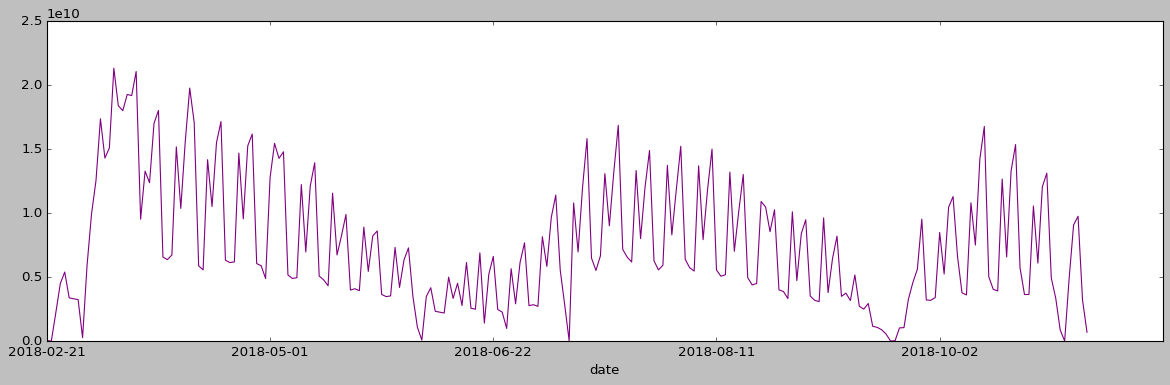

In [8]:
plt.style.use('classic')
df.groupby('date')['total_sales'].sum().plot(figsize=(18, 5), color='purple')

Total de vendas variando de acordo com os dias do ano

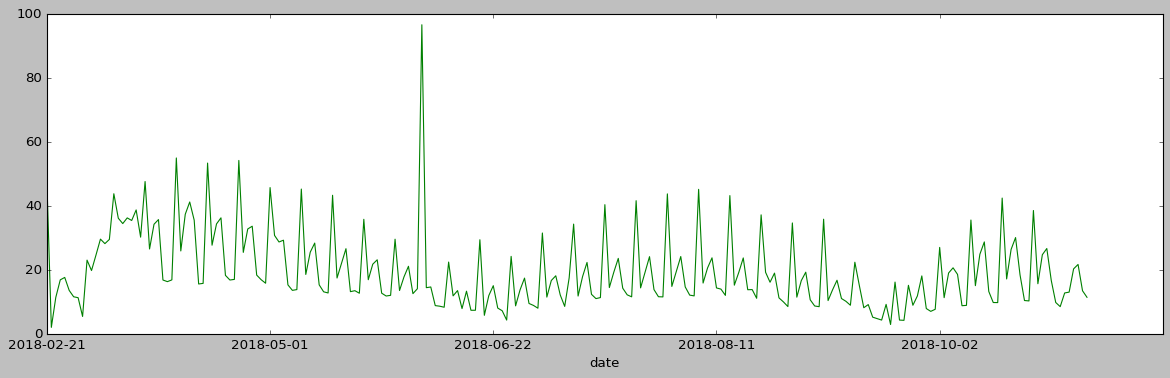

In [9]:
plt.style.use('classic')
df.groupby('date')['occu_perc'].mean().plot(figsize=(18, 5), color='green')

Porcentagem de ocupação no cinema ao longo do ano de 2018.

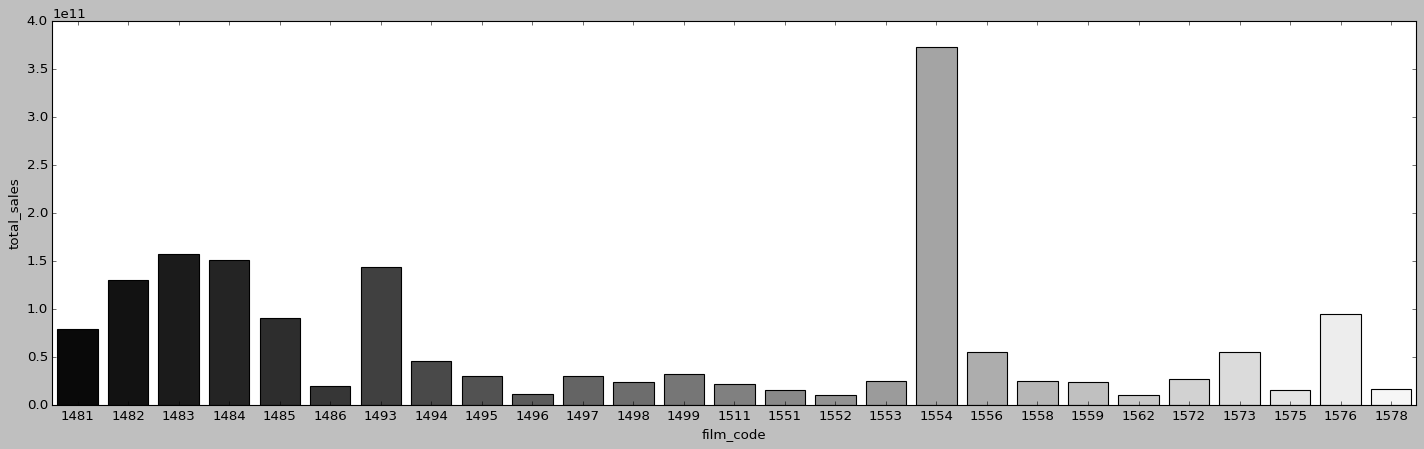

In [10]:
plt.style.use('classic')
df_plot = df.groupby('film_code', as_index=False)['total_sales'].sum()
df_plot = df_plot[df_plot.total_sales > 1e+10]
plt.figure(figsize=(22, 6))
sns.barplot(data=df_plot, x='film_code', y='total_sales', palette='gray')

Total de vendas por filme.

In [11]:
df.columns

Index(['film_code', 'cinema_code', 'total_sales', 'tickets_sold',
       'tickets_out', 'show_time', 'occu_perc', 'ticket_price', 'ticket_use',
       'capacity', 'date', 'month', 'quarter', 'day'],
      dtype='object')

Apagando colunas que não trazem conteúdo suficiente para a análise

In [12]:
del df['month']
del df['day']
del df['quarter']
del df['tickets_out']
del df['film_code']
del df['cinema_code']
del df['date']

In [13]:
df.shape

(142524, 7)

In [14]:
df = df. dropna()

Matriz de correlação para verificação depois com os PCA

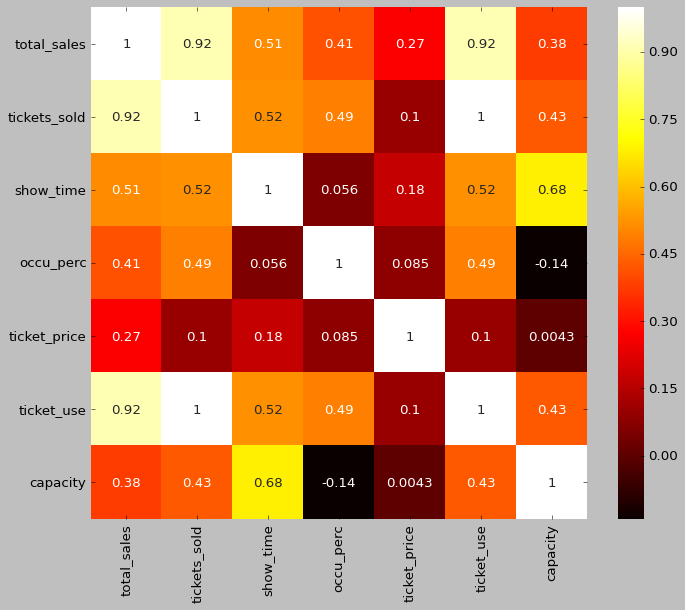

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='hot')

## Normalizando o DataFrame


Porque temos que normalizar o DataFrame? Então, os dados normalizados geralmente apresentam resultados melhores. Além disso para fazermos o PCA os dados devem estar normalizados.

In [16]:
df.columns

Index(['total_sales', 'tickets_sold', 'show_time', 'occu_perc', 'ticket_price',
       'ticket_use', 'capacity'],
      dtype='object')

In [17]:
df_1 = df.copy()

Essa cópia irá servir quando anexarmos os PCA nas features a título de vizualização. Além disso, é sabido que o PCA mantém a correlação com as features.

In [18]:
df.shape

(142399, 7)

In [19]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

In [20]:
df = min_max_scaler.fit_transform(df)
print(df)

[[3.07253723e-03 2.94186867e-03 5.08474576e-02 ... 2.13742218e-01
  2.81027759e-02 6.31651023e-02]
 [2.64491607e-03 4.82466463e-03 6.77966102e-02 ... 1.13673046e-01
  2.99380592e-02 5.38267743e-02]
 [2.01140324e-03 3.64791716e-03 5.08474576e-02 ... 1.13673046e-01
  2.87910071e-02 1.67112004e-02]
 ...
 [8.23566681e-04 8.23723229e-04 3.38983051e-02 ... 1.88724925e-01
  2.60380821e-02 9.17635962e-03]
 [4.59296803e-04 4.70698988e-04 1.69491525e-02 ... 1.70855430e-01
  2.56939665e-02 1.05218669e-02]
 [1.82134939e-04 4.70698988e-04 0.00000000e+00 ... 7.07862578e-02
  2.56939665e-02 2.90207127e-02]]


Por causa da normalização, preciso transformar esse array no DataFrame.

In [21]:
df = pd.DataFrame(df, columns=df_1.columns)
df.head(1)

,total_sales,tickets_sold,show_time,occu_perc,ticket_price,ticket_use,capacity
0,0.003073,0.002942,0.050847,0.028881,0.213742,0.028103,0.063165


Agora podemos trabalhar com a previsão do ticket_price utilizando PCA (Principal Component Analysis)

# Previsão do DataSet

## PCA (Principal Components Analysis)

Nessa parte eu tive muita dificuldade tentando uma acurácia precisa, pois esqueci de um detalhe importante sobre o PCA. Ele funciona somente para features que apresentam valores reais, dados contínuos. No meu DataFrame, minhas features são dados discretos e nesse tipo ele se torna ineficiente. Por isso não consigo atingir um valor aceitável r2_score.

### Dividindo os Dados

Colunas : total_sales', 'tickets_sold', 'show_time', 'occu_perc', 'ticket_price',
       'ticket_use', 'capacity'

Mais uma vez eu separa as colunas que apresentam mais lógica a minha análise

In [22]:
X = np.array(df[['total_sales', 'tickets_sold', 'show_time', 'occu_perc', 'ticket_use', 'capacity']])
y = np.array(df['ticket_price'])

In [23]:
X

array([[0.00307254, 0.00294187, 0.05084746, 0.02888136, 0.02810278,
        0.0631651 ],
       [0.00264492, 0.00482466, 0.06779661, 0.05477966, 0.02993806,
        0.05382677],
       [0.0020114 , 0.00364792, 0.05084746, 0.13559322, 0.02879101,
        0.0167112 ],
       ...,
       [0.00082357, 0.00082372, 0.03389831, 0.06237288, 0.02603808,
        0.00917636],
       [0.0004593 , 0.0004707 , 0.01694915, 0.03389831, 0.02569397,
        0.01052187],
       [0.00018213, 0.0004707 , 0.        , 0.01213559, 0.02569397,
        0.02902071]])

Importando a biblioteca para a análise de PCA

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

In [25]:
pca

PCA(n_components=3)

Aplicando a função .fit que  ajusta os pesos de acordo com os valores dos dados para ter uma melhor precisão possa ser alcançada.

In [26]:
pca.fit(X)

PCA(n_components=3)

In [27]:
pca.components_.shape

(3, 6)

## Porcentagem de dados em cada PCA

In [28]:
pca.explained_variance_ratio_

np.round(pca.explained_variance_ratio_, 2)

array([0.63, 0.3 , 0.04])

Somatório de cada PCA

In [29]:
pca.explained_variance_ratio_.cumsum()

array([0.63325752, 0.9371661 , 0.97376849])

Gráfico de Cotovelo

Esse gráfico nos facilita a análise do número ideal de PCA's, pois mostra a importância de cada PCA.

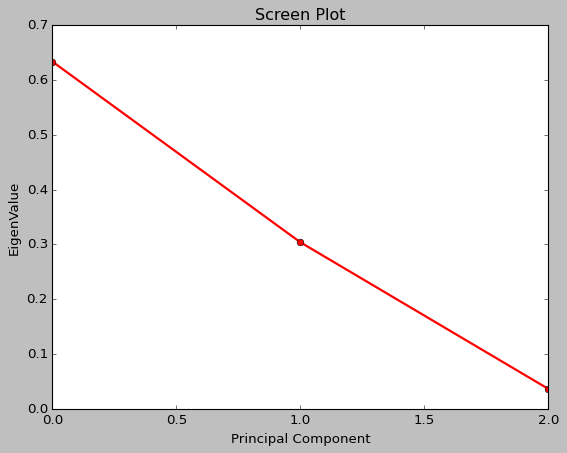

In [30]:
fig = plt.plot(figsize=(16,9))

plt.plot(pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title("Screen Plot")
plt.xlabel('Principal Component')
plt.ylabel('EigenValue')
plt.show()

Como podemos ver o número ideal para PCA é 3, por mais que 2 já compreende bastante. Afinal o 4º acrescenta somente 4%

### Gráfico diferenciado do PCA

Essa parte é um extra. Me senti desafiado a fazer um gráfico com zoom, por isso pesquisei na internet para acrescentar a minha análise.

In [31]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.63325752, 0.30390858, 0.03660239])

Coloco na variável o array de cada PCA

In [32]:
explained_variance = np.insert(explained_variance, 0, 0)

Coloco a soma cumulativa arrendondando para 3 casas decimais

In [33]:
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))

In [34]:
pc_df = pd.DataFrame(['','PC1', 'PC2', 'PC3'], columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])

Crio um DataFrame somente para isso.

In [35]:
df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)

In [36]:
fig = px.bar(df_explained_variance, 
             x='PC', y='Explained Variance',
             text='Explained Variance',
             width=800)

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.show()

### DataFrame com o PCA

Transformo o PCA numa matriz e pego cada coluna separadamento com o slicing.

In [37]:
PCA1 = pca.transform(X)[:, 0]
PCA2 = pca.transform(X)[:, 1]
PCA3 = pca.transform(X)[:, 2]

In [38]:
df['PCA1']= PCA1
df['PCA2']= PCA2
df['PCA3']= PCA3
df.head(2)

,total_sales,tickets_sold,show_time,occu_perc,ticket_price,ticket_use,capacity,PCA1,PCA2,PCA3
0,0.003073,0.002942,0.050847,0.028881,0.213742,0.028103,0.063165,-0.104631,-0.032880,0.017089
1,0.002645,0.004825,0.067797,0.054780,0.113673,0.029938,0.053827,-0.077610,-0.032612,0.028119


Coloquei esse mapa de correlação para averiguar a correlação do PCA com as outras features

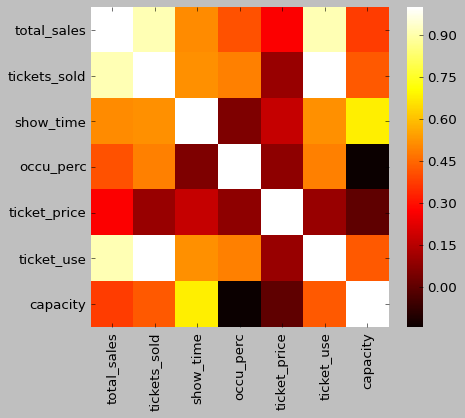

In [39]:
plt.figure(figsize=(6, 5))
sns.heatmap(df_1.corr(), annot=False, cmap='hot')

### Gráfico 3D

Assumo que esse Gráfico 3D foi inutilizável na análise, mas como estava trabalhando com dimensões quis plotar para ter uma visualização no que eu estava fazendo.

In [40]:
df.columns

Index(['total_sales', 'tickets_sold', 'show_time', 'occu_perc', 'ticket_price',
       'ticket_use', 'capacity', 'PCA1', 'PCA2', 'PCA3'],
      dtype='object')

Comentei o gráfico para não demorar tanto para executar tudo.

In [41]:
# fig = px.scatter_3d(df, x='PCA1', y='PCA2', z='PCA3',
#               color='ticket_price')

# fig.show()

## Data Split

Com a redução de dimensionalidade, usaremos para a análise somente o PCA. Por isso faço o DataSplit para separar os dados de treinamento com os dados de teste.

In [42]:
df.columns

Index(['total_sales', 'tickets_sold', 'show_time', 'occu_perc', 'ticket_price',
       'ticket_use', 'capacity', 'PCA1', 'PCA2', 'PCA3'],
      dtype='object')

In [43]:
X = np.array(df[['PCA1', 'PCA2', 'PCA3']])
y = np.array(df['ticket_price'])

In [44]:
from sklearn.model_selection import train_test_split


Nesta parte vamos preparar separar 20% do nosso DataFrame para prever os dados, e os outro 80% para treinar o DataFrame


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0 )

Tamanho de cada variável relativa a proporção de test_size que foi colocada.

In [46]:
X_train.shape , y_train.shape

((128159, 3), (128159,))

In [47]:
X_test.shape , y_test.shape

((14240, 3), (14240,))

## Regressão Linear

Os estudos de previsão começam agora.

In [48]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [49]:
model = linear_model.LinearRegression()

In [50]:
model.fit(X_train, y_train)

LinearRegression()

Nessa parte aplicamos a função .predict nos testes.

In [51]:
y_pred = model.predict(X_test)

###Resultados da Previsão

Dados da regressão linear, soma máxima da distância da reta e dos pontos, pontos que interceptam a reta, e etc. Características da regressão linear.

In [52]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_pred))

Coefficients: [0.0275249  0.02739708 0.26548911]
Intercept: 0.11550866936386454
Mean squared error (MSE): 0.00
Coefficient of determination (R^2): 0.04


Como eu havia dito no tópico inicial de PCA, minha acurácia ficou simplesmente inaceitável. Pesquisei coisas a mais, porém nesse DataFrame fica um pouco complicado por ser valores discretos.

In [53]:
r2_score(y_test, y_pred)

0.043093839070107776

Gráfico de espalhamento dos Dados

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



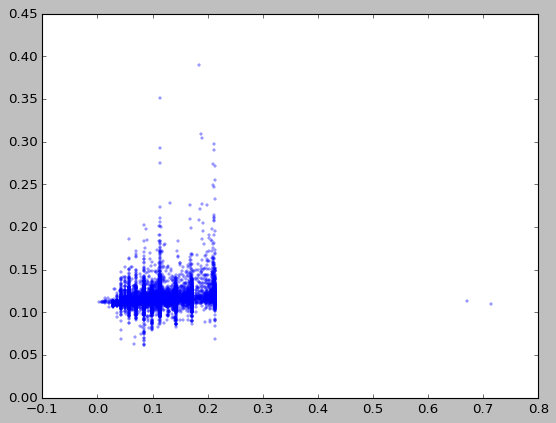

In [54]:
sns.scatterplot(y_test, y_pred, marker="+", alpha=1)

# One Hot enconding

Basicamente o One-Hot enconding é uma forma de usar dados que não necessariamente pertence a categoria numérica. Usamos ele como se fosse código. Por exemplo: Meses, janeiro, fevereiro e etc. eu posso atribuir a cada mês um número e trabalhar com ele.


Basicamente o one hot enconding é isso. Nesse meu DataFrame não tem isso, por isso não vou usar. Mas queria mostrar que estudei, afinal teria que aplicar se desse.

# Clustering


O Clustering é uma parte que não usamos o PCA, pois o seu objetivo é agrupar todas as features e trabalhar com o PCA que reduz as features não faria sentido. 

In [55]:
df.head()

,total_sales,tickets_sold,show_time,occu_perc,ticket_price,ticket_use,capacity,PCA1,PCA2,PCA3
0,0.003073,0.002942,0.050847,0.028881,0.213742,0.028103,0.063165,-0.104631,-0.032880,0.017089
1,0.002645,0.004825,0.067797,0.054780,0.113673,0.029938,0.053827,-0.077610,-0.032612,0.028119
2,0.002011,0.003648,0.050847,0.135593,0.113673,0.028791,0.016711,0.005407,-0.067944,0.020529
3,0.000934,0.001294,0.000000,0.074644,0.142264,0.026497,0.011449,-0.054879,-0.096183,0.001546
4,0.000934,0.001647,0.033898,0.113017,0.113673,0.026841,0.009488,-0.016568,-0.082798,0.015863


In [56]:
import matplotlib.pyplot as pl
%matplotlib inline

In [57]:
df.columns

Index(['total_sales', 'tickets_sold', 'show_time', 'occu_perc', 'ticket_price',
       'ticket_use', 'capacity', 'PCA1', 'PCA2', 'PCA3'],
      dtype='object')

Nessa parte quis inovar algumas features que poderiam ser usadas juntas, chamei ela de money_collection, pois ela significa o total arrecadado.

In [58]:
df['money_colletion'] = df['ticket_price']*df['total_sales']
del df['ticket_price']
del df['total_sales']

In [59]:
df.head(1)

,tickets_sold,show_time,occu_perc,ticket_use,capacity,PCA1,PCA2,PCA3,money_colletion
0,0.002942,0.050847,0.028881,0.028103,0.063165,-0.104631,-0.03288,0.017089,0.000657


Para o clustering devemos agrupar baseado em 2 features. Para achar as features que tem um significado é necessário averiguar qual pode ser o suficiente para agrupar as outras features.

In [60]:
XX = np.array(df.drop(['money_colletion', 'capacity'], axis=1))
XX

array([[ 0.00294187,  0.05084746,  0.02888136, ..., -0.1046307 ,
        -0.0328804 ,  0.01708915],
       [ 0.00482466,  0.06779661,  0.05477966, ..., -0.07761002,
        -0.03261166,  0.0281194 ],
       [ 0.00364792,  0.05084746,  0.13559322, ...,  0.00540695,
        -0.06794448,  0.02052871],
       ...,
       [ 0.00082372,  0.03389831,  0.06237288, ..., -0.06634793,
        -0.086024  ,  0.02379486],
       [ 0.0004707 ,  0.01694915,  0.03389831, ..., -0.09470979,
        -0.09298967,  0.01776263],
       [ 0.0004707 ,  0.        ,  0.01213559, ..., -0.11839598,
        -0.08441797,  0.00312254]])

## K-means

In [61]:
from sklearn.cluster import KMeans

Irei analisar a quantidade ideal de clusters para esse meu modelo.

Vario a quantidade com o range, treino o K-Means com o .fit() e anexo numa lista 

In [62]:
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42,}
# Essa configurações aqui significa : "init": "random"    -> Método de Inicialização
#                                     "n_init": 10        -> Número de vezes que o KMEANS será executado
#                                     "max_iter": 300     -> Máximo de iterações por execução 
#                                     "random_state": 42  -> Geração de números aleatórios para a inicialização

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(XX)
    sse.append(kmeans.inertia_)

Tem o mesmo objetivo do gráfico de cotovelo, averiguar qual o número ideal. Nesse caso, de clusters.

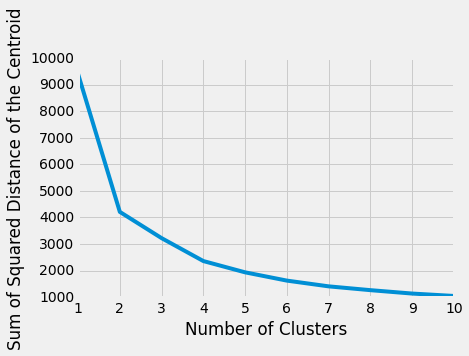

In [63]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distance of the Centroid")
plt.show()

Podemos averiguar a quantidade de SSE para cada Clusters. Podemos perceber que não temos mudança significativa de 4 cluster para 5, por isso 4 é o numero ideias de clusters.


In [64]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans_normal = kmeans.fit(XX)

Nessa parte faço a previsão de cluster's.

In [65]:
kmeans_predict = kmeans.fit_predict(XX)

In [66]:
kmeans_predict

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [67]:
df['K-means Predict']= kmeans_predict
df['K-means Actual']= kmeans_normal.labels_
df.head()

,tickets_sold,show_time,occu_perc,ticket_use,capacity,PCA1,PCA2,PCA3,money_colletion,K-means Predict,K-means Actual
0,0.002942,0.050847,0.028881,0.028103,0.063165,-0.104631,-0.032880,0.017089,0.000657,1,1
1,0.004825,0.067797,0.054780,0.029938,0.053827,-0.077610,-0.032612,0.028119,0.000301,1,1
2,0.003648,0.050847,0.135593,0.028791,0.016711,0.005407,-0.067944,0.020529,0.000229,1,1
3,0.001294,0.000000,0.074644,0.026497,0.011449,-0.054879,-0.096183,0.001546,0.000133,1,1
4,0.001647,0.033898,0.113017,0.026841,0.009488,-0.016568,-0.082798,0.015863,0.000106,1,1


Plotarei com fins de comparação os dados previsto usando o kmeans.fit_predict() e o próprio kmeans.

O kmeans é o array que tem a sequência de cluster para cada linha do meu DataFrame. O predict nos diz como que seria com novos dado, ou seja, se tivermos novos dados com esses valores das features ele estaria em que cluster.


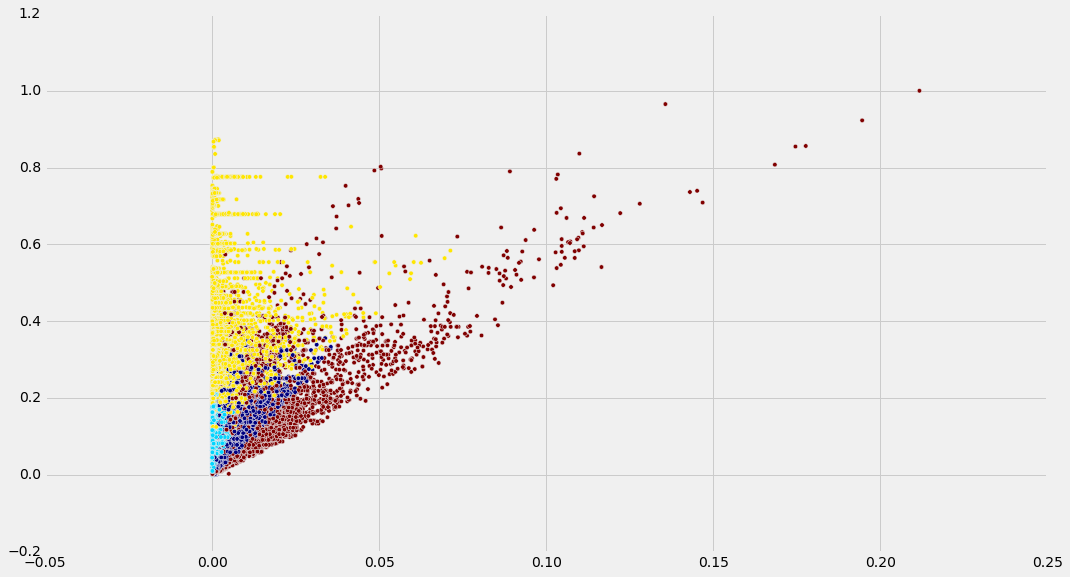

In [68]:
  plt.figure(figsize=(16, 9))
plt.scatter(df['money_colletion'], df['capacity'], c=kmeans_predict.labels_.astype(float))

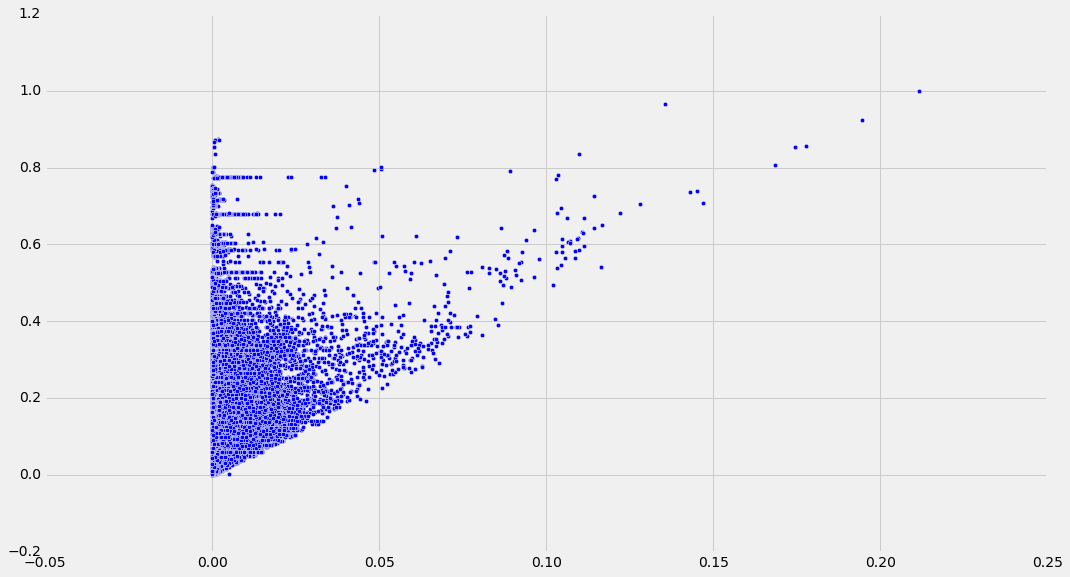

In [69]:
plt.figure(figsize=(16, 9))
plt.scatter(df['money_colletion'], df['capacity'])

Como vocês podem ver o K-means fez uma boa estimativa.